In [1]:
import matplotlib.pyplot as plt
import os
from shutil import copyfile
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
import pyathena as pa
from pyathena import ath_hst

from mpl_toolkits import axes_grid1


from matplotlib.colors import LogNorm
from six.moves import cPickle as pickle


In [2]:
unit = pa.set_units(muH=1.4271)
print(unit)
#print (unit['density'].cgs / 1.4271 / c.m_p.cgs, unit['velocity'], unit['length'])
#print unit['density']
kb = 1.3806504 * 1e-16 #boltzmann constant erg/K
vpc = 7168.*1024*1024/(128*128*896) # volume per cell


# other units can be easily obtained
# print (unit['mass'], unit['time'], unit['magnetic_field'], unit['temperature'])

# ## Read Full data cube
#
# Original data cube is stored in "vtk" files. For the MPI simulations, Athena dumps the same number of vtk files with the number of proccessors. Each vtk file has data for all physical variables for a part of the simulation "domain" (it is called "grid"). I wrote a reader to read each grid, get data from it, and merge into a big data array for full domain.

stop = 501
#simid_t = ('RPS_8pc_noICM_newacc', 'RPS_8pc_ICM1_newacc', 'RPS_8pc_ICM2_newacc')  # 'MHD_8pc_new' ,
#resol = '8pc'
simid_t = ('RPS_8pc_noICM_newacc', 'RPS_4pc_ICM1_newacc', 'RPS_4pc_ICM2_newacc')
resol = '4pc'
labell = ('No ICM', 'Weak', 'Strong', 'ICM1', 'ICM2', 'ICM3', 'ICM4')  # r'No ICM',

labelll = ('Cold','Unstable','Warm','Ionized','Hot')
C = ('goldenrod','royalblue','firebrick')
C2 = ('darkblue','deepskyblue','goldenrod','red','firebrick')
C3 = ('darkred','red','salmon')
S = (':','--','-')

# overplot Starformation rate of three different simulations

cicm = plt.cm.Reds  # RdYlBu_r,Reds
cicm._init()
x = np.arange(cicm.N)
alphas = 0.4 * (np.tanh((x - 100) / 50.) + 1)
# alphas = np.linspace(0.5, 0.5, cicm.N)
cicm._lut[:-3, -1] = alphas
cicm._lut[-3, -1] = alphas.min()
cicm._lut[-2, -1] = alphas.max()


{'number_density': <Quantity 1. 1 / cm3>, 'temperature': <Quantity 1. K>, 'density': <Quantity 0.03526822 solMass / pc3>, 'magnetic_field': <Quantity 0.54768522 uG>, 'pressure': <Quantity 2.38699871e-14 erg / cm3>, 'length': <Quantity 1. pc>, 'mass': <Quantity 0.03526822 solMass>, 'time': <Quantity 0.97779222 Myr>, 'velocity': <Quantity 1. km / s>, 'muH': <Quantity 2.38699871e-24 g>, 'gravitational_potential': <Quantity 1. km2 / s2>}


0
1
2
3
4
5
6
7
8
9


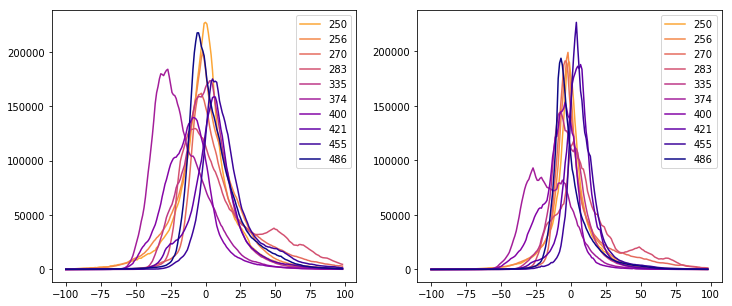

IndexError: tuple index out of range

In [5]:
for j in (1,3) :
    basedir = 'G:/yeongu/'
    simid = simid_t[j]
    Mom_up = []
    if j==2:
        snap=(250, 256, 270, 283, 312, 355, 374, 390, 408, 434) # 250, 256, 270, 283, 312, 355, 374, 390, 408, 434 / 250,260,300,330,380,410
        lsnap = len(snap)
    else:
        snap = (250, 256, 270, 283, 335, 374, 400, 421, 455, 486) # 250, 256, 270, 283, 335, 374, 400, 421, 455, 486 / 250,260,300,320,390,450
        lsnap = len(snap)
    #plt.figure(figsize=(lsnap, 5*3))
    if j==0:
        sl = 64
    else:
        sl = 128

    #hstfilename = basedir + simid + '/hst/' + simid + '.hst'
    #sn = ath_hst.read_w_pandas(hstfilename.replace('.hst', '.sn'))
    color_idx = np.linspace(0.8, 0, lsnap)
    plt.figure(figsize=(12,5))
    for k,tidx in enumerate(snap):#range(250, 499):  # time step 251, 331, 411, 501
        #plt.figure(figsize=(2.5,7))
        print k
        #surf = ('{}{}/surf/{}.{:04d}.surf.p'.format(basedir,simid,simid,tidx))
        vtkfname = '%s%s/id0/%s.%04d.vtk' % (basedir, simid, simid, tidx)
        # read in domain information
        ds = pa.AthenaDataSet(vtkfname)
        #surff = pickle.load(open(surf,'rb'))
        #print surff

        # name of original data fields we stored from the simulation
        #print(ds.field_list)

        # It also has predefined data fields can be calculated from the original data.
        #print(ds.derived_field_list)

        # full domain information
        #print ds.domain

        # information of grid #0
        #print ds.grids[0]

        # yet, we didn't read data.
        # let's read each data field in a full domain

        # this can be original data fields

        #gp = ds.read_all_data('gravitational_potential')
        #print unit['gravitational_potential']
        #print gp
        #print gp
        #T = ds.read_all_data('temperature')
        dd = ds.read_all_data('density')
        #d = ds.read_all_data('density')*unit['density'].value # density
        #print unit['']
        #pre =ds.read_all_data('pressure')*unit['pressure'].value/kb
        #mass = d # density times volume per cell = mass per cell
        #T1 = ds.read_all_data('T1')
        #coolftn = pa.coolftn()
        #temp = coolftn.get_temp(T1)  # Temperature derived from P/d & cooling func
        #nd = ds.read_all_data('number_density')*unit['number_density'].value
        #pre = pre*unit['pressure'].value/kb # thermal pressure
        #d_mks = d * 6.76745 * 1e-11  # kg/km3
        vel_z = ds.read_all_data('velocity')[:,:,:,2]

        vel_z=vel_z[dd>0.1]
        dd= dd[dd>0.1]

        hist, bin = np.histogram(vel_z,bins=np.arange(-100,100,1))
        histw, binw = np.histogram(vel_z, bins=np.arange(-100, 100, 1),weights=dd)

        plt.subplot(1,2,1)
        plt.plot(bin[0:-1],hist,label=snap[k],c=plt.cm.plasma(color_idx[k]))
        plt.legend(loc=0)

        plt.subplot(1,2,2)
        plt.plot(binw[0:-1],histw,label=snap[k],c=plt.cm.plasma(color_idx[k]))
        plt.legend(loc=0)

    plt.show()

0
1
2
3
4
5
6
7
8
9


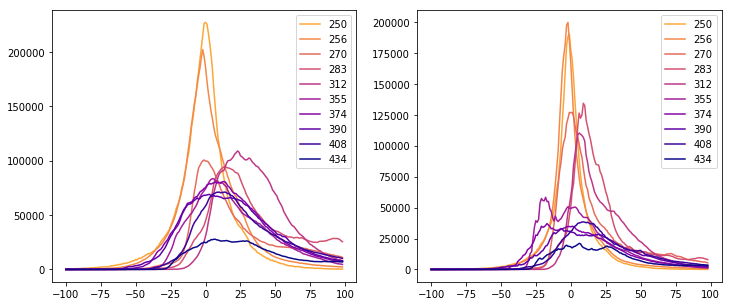

IndexError: tuple index out of range

In [6]:
for j in (2,3) :
    basedir = 'G:/yeongu/'
    simid = simid_t[j]
    Mom_up = []
    if j==2:
        snap=(250, 256, 270, 283, 312, 355, 374, 390, 408, 434) # 250, 256, 270, 283, 312, 355, 374, 390, 408, 434 / 250,260,300,330,380,410
        lsnap = len(snap)
    else:
        snap = (250, 256, 270, 283, 335, 374, 400, 421, 455, 486) # 250, 256, 270, 283, 335, 374, 400, 421, 455, 486 / 250,260,300,320,390,450
        lsnap = len(snap)
    #plt.figure(figsize=(lsnap, 5*3))
    if j==0:
        sl = 64
    else:
        sl = 128

    #hstfilename = basedir + simid + '/hst/' + simid + '.hst'
    #sn = ath_hst.read_w_pandas(hstfilename.replace('.hst', '.sn'))
    color_idx = np.linspace(0.8, 0, lsnap)
    plt.figure(figsize=(12,5))
    for k,tidx in enumerate(snap):#range(250, 499):  # time step 251, 331, 411, 501
        #plt.figure(figsize=(2.5,7))
        print k
        #surf = ('{}{}/surf/{}.{:04d}.surf.p'.format(basedir,simid,simid,tidx))
        vtkfname = '%s%s/id0/%s.%04d.vtk' % (basedir, simid, simid, tidx)
        # read in domain information
        ds = pa.AthenaDataSet(vtkfname)
        #surff = pickle.load(open(surf,'rb'))
        #print surff

        # name of original data fields we stored from the simulation
        #print(ds.field_list)

        # It also has predefined data fields can be calculated from the original data.
        #print(ds.derived_field_list)

        # full domain information
        #print ds.domain

        # information of grid #0
        #print ds.grids[0]

        # yet, we didn't read data.
        # let's read each data field in a full domain

        # this can be original data fields

        #gp = ds.read_all_data('gravitational_potential')
        #print unit['gravitational_potential']
        #print gp
        #print gp
        #T = ds.read_all_data('temperature')
        dd = ds.read_all_data('density')
        #d = ds.read_all_data('density')*unit['density'].value # density
        #print unit['']
        #pre =ds.read_all_data('pressure')*unit['pressure'].value/kb
        #mass = d # density times volume per cell = mass per cell
        #T1 = ds.read_all_data('T1')
        #coolftn = pa.coolftn()
        #temp = coolftn.get_temp(T1)  # Temperature derived from P/d & cooling func
        #nd = ds.read_all_data('number_density')*unit['number_density'].value
        #pre = pre*unit['pressure'].value/kb # thermal pressure
        #d_mks = d * 6.76745 * 1e-11  # kg/km3
        vel_z = ds.read_all_data('velocity')[:,:,:,2]

        vel_z=vel_z[dd>0.1]
        dd= dd[dd>0.1]

        hist, bin = np.histogram(vel_z,bins=np.arange(-100,100,1))
        histw, binw = np.histogram(vel_z, bins=np.arange(-100, 100, 1),weights=dd)

        plt.subplot(1,2,1)
        plt.plot(bin[0:-1],hist,label=snap[k],c=plt.cm.plasma(color_idx[k]))
        plt.legend(loc=0)

        plt.subplot(1,2,2)
        plt.plot(binw[0:-1],histw,label=snap[k],c=plt.cm.plasma(color_idx[k]))
        plt.legend(loc=0)

    plt.show()